In [1]:
import requests

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data engineering

In [4]:
# scrape the data online

my_wm_username = 'wli10'
search_url = 'http://buckets.peterbeshai.com/api/?player=201939&season=2014'
response = requests.get(search_url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"})

url = 'http://buckets.peterbeshai.com/api/?player=201939&season=2015'
data = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"})


    

cor =[]    
made = []

for shot in response.json():
    cor.append((shot['LOC_X'],shot['LOC_Y']))
    made.append(shot['EVENT_TYPE'])
    

for shots in data.json():
    cor.append((shots['LOC_X'],shots['LOC_Y']))
    made.append(shots['EVENT_TYPE'])
      
len(cor),len(made)


(2883, 2883)

In [5]:
# change 'Made shot' into 1, not made into 0;

for i in range(len(made)):
    if made[i] == 'Made Shot':
        made[i] =1
    else:
        made[i] =0
len(made)


2883

In [29]:
#change corrdinates into numpy array with shape (2,N)
x = [np.array(list(val)) for val in cor]
x = np.array(x).T
x.shape

(2, 2883)

In [30]:
# reshape y 
y = np.array(made,dtype=np.uint8).reshape(-1,len(made))
y.shape

(1, 2883)

In [31]:
# normalize and 
# divide into train and test with ratio 80:20
#m = x.shape[1]
#permu = np.random.permutation(m)
#x = x[:,permu]
n = x.shape[1]*4//5
X_train = x[:,0:n]/np.max(x)
X_test = x[:,n:]/np.max(x)
y_train = y[:,0:n]
y_test = y[:,n:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2, 2306), (2, 577), (1, 2306), (1, 577))

In [33]:
court_map = plt.imread('shotchart.png')

In [34]:
BB = (-300, 300, -50, 400)

In [35]:
def plot_data(df,BB,alpha=0.6,maps=court_map,s=10):
    fig, ax = plt.subplots(figsize=(15,10))
    #ax.scatter(df['pickup_longitude'],df['pickup_latitude'], alpha=alpha,c='r',s=s,zorder=1,marker='.')
    ax.scatter(df[0,np.where(y==1)], df[1,np.where(y==1)],zorder=2,alpha=alpha,c = 'b', s=2, cmap=plt.cm.Spectral, label='Made Shot')
    ax.scatter(df[0,np.where(y==0)], df[1,np.where(y==0)],zorder=2,alpha=alpha,c = 'r', s=2, cmap=plt.cm.Spectral, label='Miss Shot')
    ax.legend(loc=1)
    #ax.set_xlim(BB[1],BB[0])
    #ax.set_ylim(BB[3],BB[2]) 
    ax.xaxis.set_label_text('longitude')
    ax.yaxis.set_label_text('latitude')
    ax.set_title('Shooting Points')
    ax.imshow(maps, zorder=0,extent=BB)

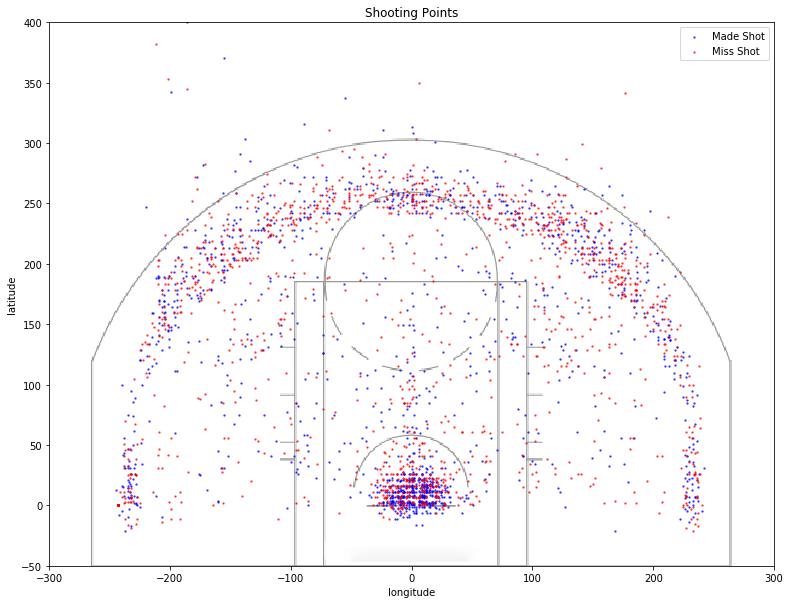

In [36]:
plot_data(x,BB)

# function define

In [37]:
# define functions

def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def tanh(Z):
    A = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache
    

def he_init(layers_dims):
    parameters = {}
    L = len(layers_dims) -1
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(np.divide(2,layers_dims[l-1]))
        parameters['b'+str(l)] = np.zeros((layers_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))   
    return parameters

def init_adam(parameters):
 
    L = len(parameters) // 2
    v = {}
    s = {}
    for l in range(L):
        v['dW'+str(l+1)]=np.zeros((parameters['W'+str(l+1)].shape))
        v['db'+str(l+1)]=np.zeros((parameters['b'+str(l+1)].shape))
        s['dW'+str(l+1)]=np.zeros((parameters['W'+str(l+1)].shape))
        s['db'+str(l+1)]=np.zeros((parameters['b'+str(l+1)].shape))
    return v,s
        

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    if activation == "tanh":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = tanh(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL+pow(10.0,-9)).T) - np.dot(1-Y, np.log(1-AL+pow(10.0,-9)).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def tanh_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    s,_ = tanh(Z)
    dZ = dA * (1-s**2)
    assert (dZ.shape == Z.shape)
    
    return dZ

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == "tanh":
        dZ = tanh_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
 
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
   # print('should be one',len(current_cache))
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
      #  print('shoub be two',len(current_cache))
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads



def update_para(parameters,grads,v,s,learning_rate=0.01, beta1 = 0.9, beta2=0.999,epsilon=1e-8):
    L = len(parameters) //2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v['dW'+str(l+1)] = beta1*v['dW'+str(l+1)]+(1-beta1)*grads['dW'+str(l+1)]
        v['db'+str(l+1)] = beta1*v['db'+str(l+1)]+(1-beta1)*grads['db'+str(l+1)]
        
        v_corrected['dW'+str(l+1)] = v['dW'+str(l+1)] / (1-np.power(beta1,l+1))
        v_corrected['db'+str(l+1)] = v['db'+str(l+1)] / (1-np.power(beta1,l+1))
        
        s['dW'+str(l+1)] = beta2*s['dW'+str(l+1)]+(1-beta2)*np.power(grads['dW'+str(l+1)],2)
        s['db'+str(l+1)] = beta2*s['db'+str(l+1)]+(1-beta2)*np.power(grads['db'+str(l+1)],2)
        
        s_corrected['dW'+str(l+1)] = s['dW'+str(l+1)] / (1-np.power(beta2,l+1))
        s_corrected['db'+str(l+1)] = s['db'+str(l+1)] / (1-np.power(beta2,l+1))

        
        
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate*np.divide(v_corrected['dW'+str(l+1)],np.sqrt(
            s_corrected['dW'+str(l+1)])+epsilon)
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*np.divide(v_corrected['db'+str(l+1)],np.sqrt(
            s_corrected['db'+str(l+1)])+epsilon)
        
    return parameters, v, s


def predict(X,y,parameters):
    m = X.shape[1]
    
    AL,cache = L_model_forward(X, parameters)
    
    p = np.zeros((1,m))
    for i in range(0,AL.shape[1]):
        if AL[0,i] > 0.5:
            p[0,i] =1
        else:
            p[0,i] =0
    acc = np.mean((p[0,:]==y[0,:]))
    
    return acc



def get_batch(X,y,batch_size):
    m = X.shape[1]
    perm = np.random.permutation(m)
    X_perm = X[:,perm]
    y_perm = y[:,perm]
    
    n = np.int(m/batch_size)
    batches = []
    for i in range(n):
        X_batch = X_perm[:,i*batch_size:(i+1)*batch_size]
        y_batch = y_perm[:,i*batch_size:(i+1)*batch_size]
        batches.append((X_batch,y_batch))
    if m%batch_size != 0:
        X_batch = X_perm[:,n*batch_size:]
        y_batch = y_perm[:,n*batch_size:]       
        batches.append((X_batch,y_batch))
    return batches
    
def predict_dec(X_test,y_test,parameters):
    AL, cache = L_model_forward(X_test, parameters)
    predictions = (AL>0.5)
    
    return predictions


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [38]:
layers_dims =[X_train.shape[0],64, 64, 64,32, 32,16,8,4, 1]
#parameters = initialize_parameters(layer_dims)
#len(parameters)

In [39]:
def L_layer_model_full(X, Y, layers_dims, learning_rate = 0.0007, mini_batch_size = 64,
                  beta1 = 0.9, beta2=0.999, epsilon = 1e-8, 
                  num_epochs = 24000, print_cost=True):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = {}
    parameters = he_init(layers_dims)
    # velocity initialization.
    v,s = init_adam(parameters)


        # Loop (gradient descent)
    for i in range(num_epochs):
        #minibatches = get_batch(X,Y,mini_batch_size)

       ## for minibatch in minibatches:
        #    (minibatch_x,minibatch_y) = minibatch

            # print(minibatch_x.shape, minibatch_y.shape)
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        layers_dims[0] = X.shape[1]
        AL, caches =  L_model_forward(X, parameters)
        ### END CODE HERE ###

        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost =  compute_cost(AL, Y)
        ### END CODE HERE ###

        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###

        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters,v,s = update_para(parameters,grads,v,s,learning_rate, beta1, beta2,epsilon)
        ### END CODE HERE ###

    # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.690761
Cost after iteration 100: 0.657586
Cost after iteration 200: 0.652568
Cost after iteration 300: 0.649808
Cost after iteration 400: 0.646673
Cost after iteration 500: 0.643827
Cost after iteration 600: 0.641006
Cost after iteration 700: 0.638582
Cost after iteration 800: 0.635995
Cost after iteration 900: 0.633739
Cost after iteration 1000: 0.631468
Cost after iteration 1100: 0.629314
Cost after iteration 1200: 0.627073
Cost after iteration 1300: 0.624630
Cost after iteration 1400: 0.621874
Cost after iteration 1500: 0.619265
Cost after iteration 1600: 0.616547
Cost after iteration 1700: 0.614364
Cost after iteration 1800: 0.612841
Cost after iteration 1900: 0.610719
Cost after iteration 2000: 0.609609
Cost after iteration 2100: 0.607862
Cost after iteration 2200: 0.606319
Cost after iteration 2300: 0.604689
Cost after iteration 2400: 0.603440
Cost after iteration 2500: 0.601800
Cost after iteration 2600: 0.600569
Cost after iteration 2700: 0.599582
Cost

Cost after iteration 22500: 0.499274
Cost after iteration 22600: 0.496677
Cost after iteration 22700: 0.499466
Cost after iteration 22800: 0.498820
Cost after iteration 22900: 0.496818
Cost after iteration 23000: 0.496697
Cost after iteration 23100: 0.496484
Cost after iteration 23200: 0.495458
Cost after iteration 23300: 0.495250
Cost after iteration 23400: 0.495333
Cost after iteration 23500: 0.496357
Cost after iteration 23600: 0.495283
Cost after iteration 23700: 0.498580
Cost after iteration 23800: 0.493682
Cost after iteration 23900: 0.497779


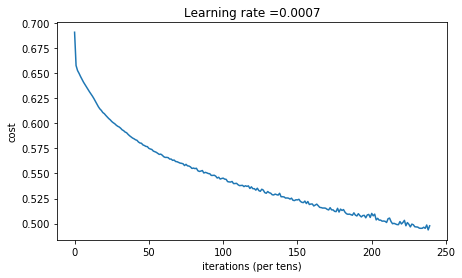

In [40]:
para = L_layer_model_full(X_train, y_train, layers_dims, print_cost = True)


In [41]:
predictions_train = predict(X_train, y_train, para)
print ("On the training set:",predictions_train)

predictions_test = predict(X_test, y_test, para)
print ("On the test set:",predictions_test)

On the training set: 0.7354726799653079
On the test set: 0.5060658578856152


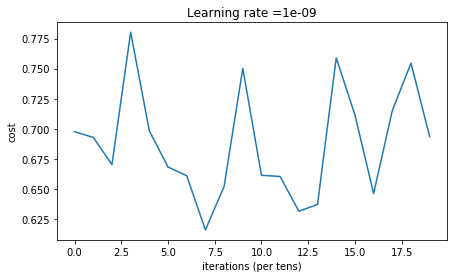

***************************************
learning_rate = 0.00000000
train accuracy: 0.4844
validation accuracy: 0.5667


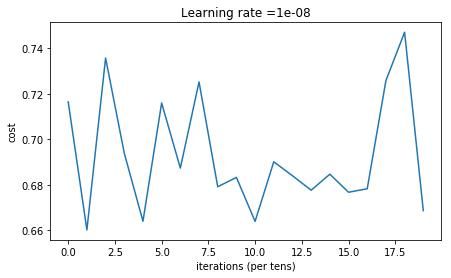

***************************************
learning_rate = 0.00000001
train accuracy: 0.5130
validation accuracy: 0.4281


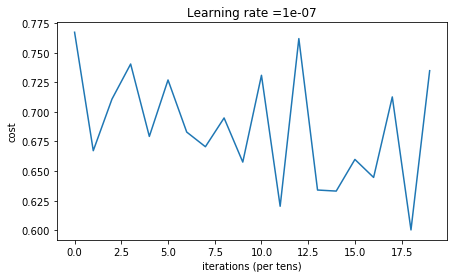

***************************************
learning_rate = 0.00000010
train accuracy: 0.5082
validation accuracy: 0.4350
lr 1.000000e-09 train accuracy: 0.484389 val accuracy: 0.566724
lr 1.000000e-08 train accuracy: 0.513010 val accuracy: 0.428076
lr 1.000000e-07 train accuracy: 0.508239 val accuracy: 0.435009
best validation accuracy achieved during cross-validation: 0.566724


In [66]:
results = {}
best_val = -1
learning_rates = [1e-9, 1e-8, 1e-7]


for lr in learning_rates:
    
   
    para = L_layer_model_full(X_train, y_train, layers_dims, print_cost = True, learning_rate=lr)

    predictions_train_acc = predict(X_train, y_train, para)
    
    predictions_val_acc = predict(X_val, y_val, para)
 
    print('***************************************')
    print('learning_rate = %.8f' %lr)

    print ('train accuracy: %.4f' %predictions_train_acc)
    print ('validation accuracy: %.4f' %predictions_val_acc)
    acc = (predictions_train_acc, predictions_val_acc)
    results[lr]=acc 
    
    # check if validation accuracy is best or not
    if best_val < predictions_val_acc:
        best_val = predictions_val_acc


for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)